In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [44]:
from google.cloud import bigquery

client = bigquery.Client()

dataset_ref = client.dataset("medicare", project = "bigquery-public-data")

dataset = client.get_dataset(dataset_ref)


Using Kaggle's public dataset BigQuery integration.


In [45]:
tables = list(client.list_tables(dataset))
list_of_tables = [table.table_id for table in tables]

print(list_of_tables)

['inpatient_charges_2011', 'inpatient_charges_2012', 'inpatient_charges_2013', 'inpatient_charges_2014', 'outpatient_charges_2011', 'outpatient_charges_2012', 'outpatient_charges_2013', 'outpatient_charges_2014', 'part_d_prescriber_2014', 'physicians_and_other_supplier_2012', 'physicians_and_other_supplier_2013', 'physicians_and_other_supplier_2014']


In [46]:
#Goal: To see the percent increase in medicare charges that companies charge in 2014 compared to 2011 for outperson patients
#See the impact that medicare has had in the span of 3 years, for non-serious cases
#The drastic climb in prices


percent_increase_query = """
WITH AverageCharges2011 AS (
    SELECT provider_id, provider_name,AVG(average_estimated_submitted_charges) AS avg_charges_2011
    FROM `bigquery-public-data.medicare.outpatient_charges_2011` 
    GROUP BY provider_id, provider_name
),
AverageCharges2014 AS (
    SELECT provider_id,provider_name,AVG(average_estimated_submitted_charges) AS avg_charges_2014
    FROM `bigquery-public-data.medicare.outpatient_charges_2014` 
    GROUP BY provider_id, provider_name
)

SELECT 
    a.provider_id,
    a.provider_name,
    a.avg_charges_2011,
    b.avg_charges_2014,
    CASE 
        WHEN a.avg_charges_2011 > 0 THEN 
            ((b.avg_charges_2014 - a.avg_charges_2011) / a.avg_charges_2011) * 100
        ELSE NULL
    END AS percent_increase
FROM AverageCharges2011 a
JOIN AverageCharges2014 AS b 
    ON a.provider_id = b.provider_id
ORDER BY percent_increase DESC

"""

percent_increase_query_job = client.query(percent_increase_query)

percent_increase_results = percent_increase_query_job.to_dataframe()

percent_increase_results.head()

,provider_id,provider_name,avg_charges_2011,avg_charges_2014,percent_increase
0,450620,DIMMIT COUNTY MEMORIAL HOSPITAL,251.156250,4745.983846,1789.653889
1,450871,AUSTIN SURGICAL HOSPITAL,535.191698,3441.843337,543.104770
2,50732,FRESNO HEART AND SURGICAL HOSPITAL,381.389084,1954.942061,412.584692
3,370216,TULSA SPINE & SPECIALTY HOSPITAL,677.524939,3187.891760,370.520209
4,670002,SOUTH HAMPTON COMMUNITY HOSPITAL,1731.062447,7735.798401,346.881533


In [47]:
#Goal: To see the price difference of inpatient vs outpatient treatments in 2014
#For patients to have access to financial data to make a decision on where they can get treatement locally (as data is ordered by city, state, it makes it easy for patients or potential medicare buyers to access data local to them)
#To show the cheapest and most expensive cities to acquire medicare from

in_vs_out_query = """
WITH InpatientCosts AS (
    SELECT provider_city, provider_state, AVG(average_total_payments) AS avg_inpatient_cost
    FROM `bigquery-public-data.medicare.inpatient_charges_2014` 
    GROUP BY provider_city, provider_state
),
OutpatientCosts AS (
    SELECT provider_city, provider_state, AVG(average_total_payments) AS avg_outpatient_cost
    FROM `bigquery-public-data.medicare.outpatient_charges_2014` 
    GROUP BY provider_city, provider_state
)

SELECT 
    i.provider_city,
    i.provider_state,
    i.avg_inpatient_cost,
    o.avg_outpatient_cost
FROM InpatientCosts AS i
INNER JOIN OutpatientCosts AS o 
    ON i.provider_city = o.provider_city AND i.provider_state = o.provider_state
ORDER BY 
    i.provider_state, 
    i.provider_city
"""

in_vs_out_query_job = client.query(in_vs_out_query)

in_vs_out_results = in_vs_out_query_job.to_dataframe()

in_vs_out_results.head()

,provider_city,provider_state,avg_inpatient_cost,avg_outpatient_cost
0,ANCHORAGE,AK,24575.243749,307.189135
1,FAIRBANKS,AK,18504.897469,321.200915
2,JUNEAU,AK,12403.389668,394.824964
3,PALMER,AK,13783.041544,206.447570
4,SOLDOTNA,AK,11871.794381,313.840960


In [48]:
#Goal: To see the most prescribed drug in each state
#Allows us to get a face-value impression of the medical issues that a large portion of medical prescription users in each state have
#Useful for targeting certain groups of people, commericals, opportunities, financial marketing choices

most_used_drug_query = """
WITH DrugRankings AS (
    SELECT 
        nppes_provider_state, 
        generic_name, 
        SUM(bene_count) AS total_bene_count,
        ROW_NUMBER() OVER (PARTITION BY nppes_provider_state ORDER BY SUM(bene_count) DESC) AS rank
    
    FROM `bigquery-public-data.medicare.part_d_prescriber_2014` 
    GROUP BY nppes_provider_state, generic_name
)

SELECT 
    nppes_provider_state,
    generic_name,
    total_bene_count
FROM 
    DrugRankings
WHERE 
    rank = 1
ORDER BY 
    nppes_provider_state
"""

most_used_drug_query_job = client.query(most_used_drug_query)

most_used_drug_results = most_used_drug_query_job.to_dataframe()

most_used_drug_results.head()

,nppes_provider_state,generic_name,total_bene_count
0,AA,AMOXICILLIN,195
1,AE,HYDROCODONE/ACETAMINOPHEN,417
2,AK,HYDROCODONE/ACETAMINOPHEN,8584
3,AL,HYDROCODONE/ACETAMINOPHEN,347939
4,AP,HYDROCODONE/ACETAMINOPHEN,171


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

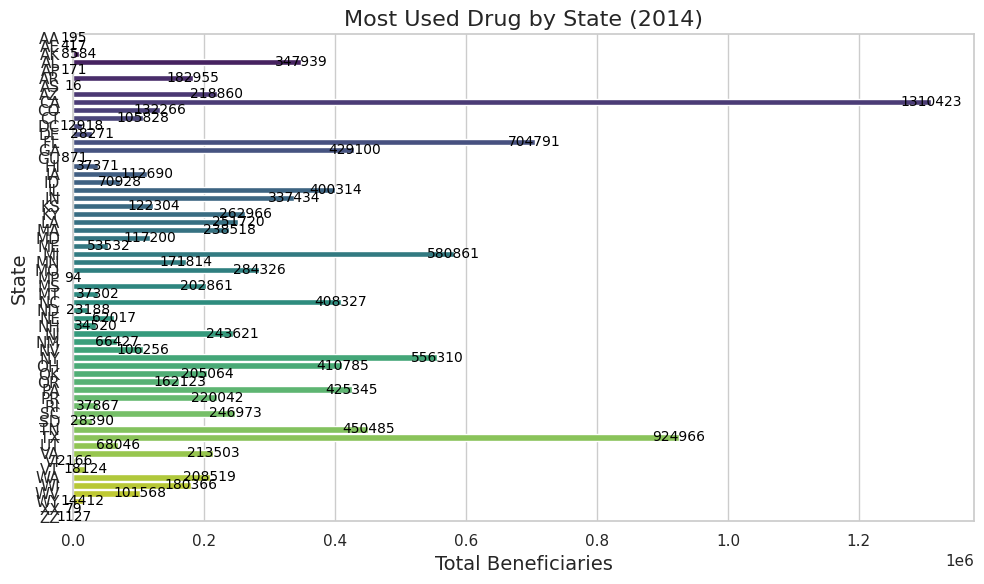

In [50]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a bar plot with adjusted size
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='total_bene_count', y='nppes_provider_state', data=most_used_drug_results, palette='viridis')

# Add data labels on the bars
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_width())}', (p.get_width() + 50, p.get_y() + p.get_height() / 2), 
                      ha='center', va='center', color='black', fontsize=10)

# Add title and labels
plt.title('Most Used Drug by State (2014)', fontsize=16)
plt.xlabel('Total Beneficiaries', fontsize=14)
plt.ylabel('State', fontsize=14)

# Show the plot
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()


In [ ]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Melt the DataFrame for easier plotting
melted_data = pd.melt(in_vs_out_results, id_vars=['provider_city', 'provider_state'], 
                       value_vars=['avg_inpatient_cost', 'avg_outpatient_cost'], 
                       var_name='treatment_type', value_name='average_cost')

# Create the bar plot
plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(x='average_cost', y='provider_city', hue='treatment_type', data=melted_data, palette='muted')

# Add data labels on the bars
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_width())}', (p.get_width() + 50, p.get_y() + p.get_height() / 2), 
                      ha='center', va='center', color='black', fontsize=10)

# Add title and labels
plt.title('Inpatient vs Outpatient Treatment Costs in 2014', fontsize=16)
plt.xlabel('Average Cost ($)', fontsize=14)
plt.ylabel('City', fontsize=14)
plt.legend(title='Treatment Type')
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()